In [1]:
import os
import cv2
from skimage.measure import block_reduce

from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def train_data_loader(data_path, img_size, output_path):
    label_list = []
    img_list = []
    label_idx = 0

    for root, dirs, files in os.walk(data_path):
        if not files:
            continue
        for filename in files:
            img_path = os.path.join(root, filename)
#             print(img_path)
            try:
                img = cv2.imread(img_path, 1)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
#                 plt.imshow(img)
            except:
                print('exception in reading & resizing image')
                continue
            label_list.append(img_path.split(os.sep)[-2])
            img_list.append(img)
        label_idx += 1

    # write output file for caching
#     with open(output_path[0], 'wb') as img_f:
#         pickle.dump(img_list, img_f)
#     with open(output_path[1], 'wb') as label_f:
#         pickle.dump(label_list, label_f)
    return (label_list, img_list)

In [3]:
dataset_path = '../data'
print('dataset path: {}'.format(dataset_path))

label_list, img_list = train_data_loader(dataset_path, (224,224), None)

dataset path: ../data


In [4]:
print('length of img_list: {}'.format(len(img_list)))

print('shape of one image: {}'.format(img_list[0].shape))

length of img_list: 67
shape of one image: (224, 224, 3)


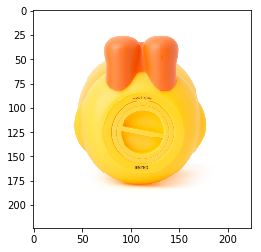

In [5]:
plt.imshow(img_list[0])

In [6]:
def l2_normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0:
        return v
    return v / norm

In [7]:
def global_max_pool_2d(v):
    v_reduced = block_reduce(v, block_size=(1, v.shape[1], v.shape[2], 1), func=np.max)
    print(v_reduced.shape)
    return v_reduced

def global_sum_pool_2d(v):
    v_reduced = block_reduce(v, block_size=(1, v.shape[1], v.shape[2], 1), func=np.sum)
    print(v_reduced.shape)
    return v_reduced


In [8]:
def pca_whiten(m):
    pca = PCA(whiten=True)
    whitened = pca.fit_transform(m)
    return whitened

In [9]:
query_vecs = np.random.rand(195, 7, 7, 1024)
reference_vecs = np.random.rand(1127, 7, 7, 1024)

print('query_vecs.shape: {}, reference_vecs.shape: {}'.format(query_vecs.shape, reference_vecs.shape))

query_vecs.shape: (195, 7, 7, 1024), reference_vecs.shape: (1127, 7, 7, 1024)


In [10]:
query_vecs = global_max_pool_2d(query_vecs)
reference_vecs = global_max_pool_2d(reference_vecs)

(195, 1, 1, 1024)
(1127, 1, 1, 1024)


In [11]:
query_vecs = query_vecs.reshape(query_vecs.shape[0], -1) # Flattens 1x1 components
reference_vecs = reference_vecs.reshape(reference_vecs.shape[0], -1)

print('query_vecs.shape: {}, reference_vecs.shape: {}'.format(query_vecs.shape, reference_vecs.shape))

query_vecs.shape: (195, 1024), reference_vecs.shape: (1127, 1024)


In [12]:
combined = np.concatenate((query_vecs, reference_vecs), axis=0)
print('shape of combined:', combined.shape)

shape of combined: (1322, 1024)


In [13]:
combined = l2_normalize(combined)
combined_whitened = pca_whiten(combined)
print('dimensions after whitening:', combined_whitened.shape)
combined_final = l2_normalize(combined_whitened)

dimensions after whitening: (1322, 1024)


In [16]:
query_vecs = combined_final[:query_vecs.shape[0]]
reference_vecs = combined_final[reference_vecs.shape[0]:]

print('query_vecs.shape: {}, reference_vecs.shape: {}'.format(query_vecs.shape, reference_vecs.shape))

query_vecs.shape: (195, 1024), reference_vecs.shape: (1127, 1024)


In [15]:
sim_matrix = np.dot(query_vecs, reference_vecs.T)
print('shape of sim_matrix:', sim_matrix.shape)
print(sim_matrix)

shape of sim_matrix: (195, 195)
[[0.0007567  0.00075579 0.00075573 ... 0.00075622 0.00075648 0.00075575]
 [0.00075638 0.00075545 0.00075538 ... 0.00075588 0.00075615 0.00075543]
 [0.00075702 0.00075609 0.00075604 ... 0.00075652 0.0007568  0.00075608]
 ...
 [0.00075679 0.00075587 0.00075583 ... 0.0007563  0.00075658 0.00075585]
 [0.00075708 0.00075616 0.00075612 ... 0.00075658 0.00075687 0.00075614]
 [0.00075639 0.00075546 0.00075542 ... 0.0007559  0.00075617 0.00075544]]
